In [2]:
import astropy
import astropy.units as u
from astropy.coordinates import SkyCoord
import os
import numpy as np
import specsim.simulator
from speclite import filters
from speclite import redshift
from astropy.constants import h, c, k_B, sigma_sb
from astropy.cosmology import Planck18
from astropy.table import Table, join
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import interp1d
import bed
from bed.grid import Grid, PermutationInvariant
from bed.design import ExperimentDesigner
from bed.grid import TopHat
from lsstetc import ETC
import galsim

from functions import *

In [2]:
def F_blackbody(wavelength, T = 5000 * u.K):
    """
    Compute the blackbody surface flux density (per unit wavelength)
    in the rest frame of the blackbody.

    Args
    ----------
    wavelength : Quantity
        Wavelength(s), must have units (e.g. u.AA, u.nm, u.um).
    T (temperature) : Quantity
        Temperature with units of Kelvin.

    Returns
    -------
    flux_density : array
        Flux density (erg / s / cm² / Å), i.e., total emitted flux from the surface.
    """

    exponent = (h.cgs * c.cgs) / (wavelength.to(u.cm) * k_B.cgs * T.to(u.K))
    # specific intensity from a blackbody emitter
    B = (2 * h.cgs * c.cgs**2) / (wavelength.to(u.cm)**5 * (np.exp(exponent.value) - 1))
    # surface flux density (integrated over solid angle)
    F = np.pi * B

    return F.to(u.erg / (u.s * u.cm**2 * u.AA))

def L_blackbody(wavelength, T = 5000 * u.K):
    """
    Compute the blackbody rest-frame luminosity at a given wavelength and temperature.

    Args
    wavelength : array
        Wavelength(s), must have units (e.g. u.AA, u.nm, u.um).
    T (temperature) : float
        Temperature with units of Kelvin.

    Returns
    -------
    luminosity : array
        Luminosity (erg / s), i.e., total emitted flux from the surface.
    """
    L_sun = 3.826e33 * u.erg / u.s # Solar luminosity
    L_bol = 1e9 * L_sun # a standard Bolometric luminosity of a galaxy in Solar luminosities
    # Calculate the effective radius of the blackbody in cm
    R_eff = np.sqrt(L_bol / (4 * np.pi * sigma_sb.to(u.erg / (u.s * u.cm**2 * u.K**4)) * T**4))
    return 4 * np.pi * R_eff**2 * F_blackbody(wavelength, T)

def F_observed(z, wavelength, T = 5000 * u.K):
    """
    Compute the observed flux in wavelength of a blackbody at a given wavelength and temperature.

    Args
    z : float
        Redshift.
    wavelength : array
        Wavelength(s), must have units (e.g. u.AA, u.nm, u.um).
    T (temperature) : float
        Temperature with units of Kelvin.

    Returns
    -------
    flux : array
        Flux in wavelength (erg / s / cm² / Å).
    """
    return L_blackbody(wavelength.reshape(1, -1) / (1+z), T) / ((1+z) * (4 * np.pi * Planck18.luminosity_distance(z).to(u.cm)**2))

def F_b(z, f, T = 5000 * u.K):
    """
    Compute the integrated band (filter) photon flux of a blackbody at a given redshift, filter, temperature, and radius.

    Args
    z : float (or array)
        Redshift.
    f (filter) : str
        LSST filter name. "u", "g", "r", "i", "z", "y"

    Returns
    -------
    photon flux : float (or array)
        Flux in band (1 / s / cm²).
    """
    loaded_filter = filters.load_filter("lsst2023-"+f)
    wlen = loaded_filter.wavelength * u.AA
    return np.trapezoid(F_observed(z, wlen, T) * loaded_filter(wlen) * (wlen / (h * c).to(u.erg * u.Angstrom)), wlen)

def photon_count(t_exp, z, f, A = 33.2 * u.m**2, T = 5000 * u.K):
    """
    Compute the number of photons in a given exposure time, redshift, filter, and temperature.

    Args
    t_exp : float
        Exposure time in seconds.
    z (redshift) : float
        Redshift.
    f (filter) : str
        LSST filter name. "u", "g", "r", "i", "z", "y"
    T (temperature) : float
        Temperature with units of Kelvin.

    Returns
    -------
    photons : float
        Number of photons in the band.
    """
    # convert t_exp to seconds if it's a float, otherwise ensure it has time units
    if isinstance(t_exp, (int, float)):
        t_exp = t_exp * u.s
    else:
        t_exp = t_exp.to(u.s)
    return F_b(z, f, T) * t_exp * A.to(u.cm**2)

def M_b(z, f, T = 5000 * u.K):
    """
    Compute the magnitude of a blackbody at a given redshift, filter, temperature, and radius.

    Args
    z : float (or array)
        Redshift.
    f (filter) : str
        LSST filter name. "u", "g", "r", "i", "z", "y"

    Returns
    -------
    magnitude : float (or array)
        Magnitude in the input filter band.
    """
    # convert z to array if it is a scalar
    if not isinstance(z, np.ndarray):
        z = np.array([z])
    # get the wavelength coverage of the filter
    wlen = filters.load_filter("lsst2023-"+f).wavelength * u.AA
    return filters.load_filter("lsst2023-"+f).get_ab_magnitude(F_observed(z.reshape(-1, 1), wlen, T), wlen)

In [4]:
F_b(0.1, "i")

<Quantity [0.00400959] 1 / (s cm2)>

In [5]:
photon_count(30, 0.05, 'i').item()

<Quantity 172459.13679716>

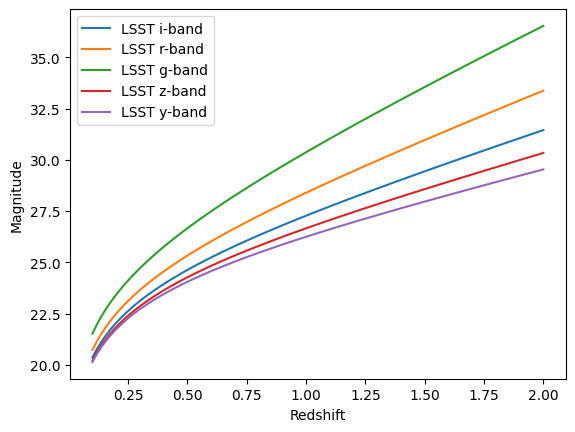

In [6]:
plt.plot(np.linspace(0.1, 2, 100), M_b(np.linspace(0.1, 2, 100), "i"), label = "LSST i-band")
plt.plot(np.linspace(0.1, 2, 100), M_b(np.linspace(0.1, 2, 100), "r"), label = "LSST r-band")
plt.plot(np.linspace(0.1, 2, 100), M_b(np.linspace(0.1, 2, 100), "g"), label = "LSST g-band")
plt.plot(np.linspace(0.1, 2, 100), M_b(np.linspace(0.1, 2, 100), "z"), label = "LSST z-band")
plt.plot(np.linspace(0.1, 2, 100), M_b(np.linspace(0.1, 2, 100), "y"), label = "LSST y-band")
plt.legend()
plt.xlabel("Redshift")
plt.ylabel("Magnitude")
plt.show()

In [7]:
band = "i"
pixel_scale = 0.2 # arcsec
stamp_size = 31 # pixels
threshold = 0.0
nvisits = 50
visit_time = 15
etc = ETC(band, pixel_scale=pixel_scale, stamp_size=stamp_size,
              threshold=threshold, nvisits=nvisits, visit_time=visit_time)

In [9]:
gal = galsim.Gaussian(flux=1e5, sigma=1) # sigma = 2 arcsec
psf = galsim.Gaussian(fwhm=0.67) # Full-width half-max of the PSF in arcseconds

profile = galsim.Convolve([gal, psf])

img = profile.drawImage(scale=pixel_scale)

gd = galsim.GaussianNoise(galsim.BaseDeviate(1), sigma=etc.sigma_sky)
img.addNoise(gd)

In [8]:
photon_count(30, 0.05, 'i').item()

<Quantity 172459.13679716>

In [18]:
np.sqrt(np.var(np.array(vals)))

np.float32(4995639.5)

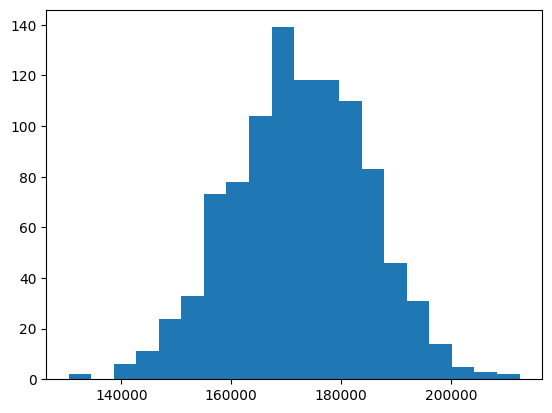

In [19]:
vals = []
for i in range(1000):
    profile = profile.withFlux(photon_count(30, 0.05, 'i').item())
    img = profile.drawImage(image=img)
    gd = galsim.GaussianNoise(galsim.BaseDeviate(i), sigma=etc.sigma_sky)
    img.addNoise(gd)
    vals.append(np.sum(img.array))

plt.hist(vals, bins=20)
plt.show()